# Langevin Monte Carlo

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

/DYZ/dyz1/anaconda3/envs/gnn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


通过模拟Langevin随机微分方程(SDE)提出了新的采样

$d X_t=-\nabla U\left(X_t\right) d t+\sqrt{2} d B_t$                         
$U$是势函数，$B_t$是标准布朗运动。

让$U(\mathbf{z})=\frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2-\log \left(e^{-0.5\left[\frac{\mathbf{z}_1-2}{0.6}\right]}+e^{-0.5\left[\frac{\mathbf{z}_1+2}{0.6}\right]}\right)$和$p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$是我们想要抽样的分布。

让我们想象一下(非标准化的)密度。

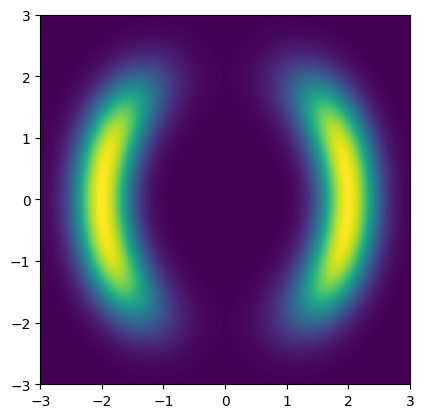

In [2]:
def npdensity1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

**未调整朗格万算法(ULA)**
Langevin SDE可以用Euler-Maruyama格式模拟如下           
$X_{k+1}=X_k-\gamma_{k+1} \nabla U\left(X_k\right)+\sqrt{2 \gamma_{k+1}} Z_{k+1}$

其中$\gamma_{k+1}$为步长，$Z_{k+1}$为第$k+1$个时间步长$\mathcal{N}(0, I)$的采样。

在实践中，有各种各样的技巧来设置$\gamma_{k+1}$和$X_0$，初始种子。然而，在下面的例子中，我使用了一个恒定的步长，并从$\mathcal{N}(0, I)$中采样$X_0$。

上面的朗之万动力学模拟可以用来从形式$p(x)=\frac{e^{-U(x)}}{Z}$的密度中抽取样本，其中$Z$可能已知，也可能不知道。假设$U$的梯度为L-Lipschtiz。

In [3]:
def potential(z):
    z = z.view(-1, 2)
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

In [7]:
def unadjusted_langevin_algorithm(n_samples=100000, step=0.01):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    for i in range(n_samples + burn_in):
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

运行ULA并渲染经验密度。

In [8]:
samples = unadjusted_langevin_algorithm()

Exception ignored in: <function tqdm.__del__ at 0x7fda70ce6040>
Traceback (most recent call last):
  File "/DYZ/dyz1/anaconda3/envs/gnn/lib/python3.8/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/DYZ/dyz1/anaconda3/envs/gnn/lib/python3.8/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


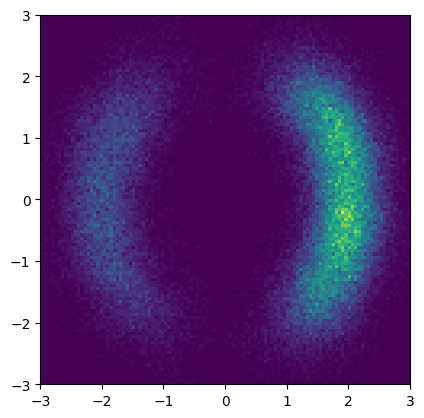

In [9]:
plt.hist2d(samples[:,0], samples[:,1], cmap='viridis', rasterized=False, bins=128)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

## Metropolis-adjusted朗格万算法(MALA)

如前所述，使用Euler Maruyama方案提出新采样，但使用Metropolis Hastings算法接受/拒绝，即接受概率由
$$\alpha=\min \left\{1, \frac{p\left(x_{k+1}\right) Q\left(x_k \mid x_{k+1}\right)}{p\left(x_k\right) Q\left(x_{k+1} \mid x_k\right)}\right\}$$
其中
$$Q\left(x^{\prime} \mid x\right) \propto \exp \left(-\frac{1}{4 \gamma}\left\|x^{\prime}-x+\gamma \nabla U(x)\right\|^2\right)$$

In [10]:
def log_Q(z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(n_samples=100000, step=0.01):
    burn_in = 10000
    Z0 = torch.randn(1, 2)
    Zi = Z0
    samples = []
    pbar = tqdm(range(n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, 2)
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(Zi, prop_Zi, step) - log_Q(prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

In [11]:
samples = metropolis_adjusted_langevin_algorithm()

/tmp/ipykernel_18482/3666795077.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(range(n_samples + burn_in))


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html